# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [2]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


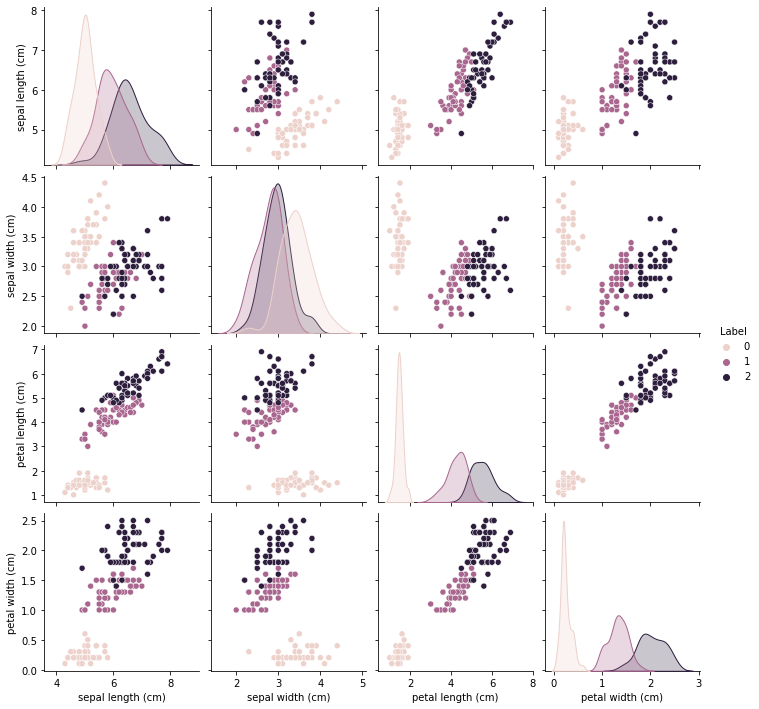

In [12]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0..1]. This can be done either using plain `numpy` operations, or [Scikit Learn methods](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

Also, you need to decide if you want target label to be one-hot encoded or not. PyTorch and TensorFlow allow you feed in class number either as an integer (from 0 to N-1), or as one-hot encoded vector. When creating neural network structure, you need to specify loss function accordingly (eg. *sparse categorical crossentropy* for numeric representation, and *crossentropy loss* for one-hot encoding). One-hot encoding can also be [done using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), or by using this piece of code:

```python
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]
``` 

In [3]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch

scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)
labels_encoded = labels

X = torch.tensor(features_norm, dtype=torch.float32)
Y = torch.tensor(labels_encoded, dtype=torch.long)

### Split the Data into Train and Test

Since we do not have separate train and test dataset, we need to split it intro train and test dataset [using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

### Define and Train Neural Network

Now you are ready to go, import your preferred framework, define the neural network and start training, observing the behavior of train and validation accuracy.

In [8]:
import torch.nn as nn
import torch.optim as optim

class IrisNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(IrisNet, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.fc(x)
    
input_dim = X_train.shape[1]
output_dim = len(torch.unique(y_train))
model = IrisNet(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [9]:
num_epochs = 100

history = {
    "train_loss": [],
    "train_acc": [],
    "test_acc": []
}

for epoch in range(num_epochs):
    model.train() 
    optimizer.zero_grad()  
    outputs = model(X_train)  
    loss = criterion(outputs, y_train)  
    loss.backward()  
    optimizer.step()

   
    model.eval()  
    with torch.no_grad():
        train_pred = torch.argmax(model(X_train), dim=1)
        train_acc = (train_pred == y_train).float().mean().item() 
        test_pred = torch.argmax(model(X_test), dim=1)  
        test_acc = (test_pred == y_test).float().mean().item() 

    history["train_loss"].append(loss.item())
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch [10/100], Loss: 1.0131, Train Acc: 0.6583, Test Acc: 0.6667
Epoch [20/100], Loss: 0.9463, Train Acc: 0.7083, Test Acc: 0.6333
Epoch [30/100], Loss: 0.8872, Train Acc: 0.6917, Test Acc: 0.6667
Epoch [40/100], Loss: 0.8355, Train Acc: 0.6833, Test Acc: 0.6667
Epoch [50/100], Loss: 0.7902, Train Acc: 0.7417, Test Acc: 0.7333
Epoch [60/100], Loss: 0.7506, Train Acc: 0.7833, Test Acc: 0.7667
Epoch [70/100], Loss: 0.7156, Train Acc: 0.8250, Test Acc: 0.7667
Epoch [80/100], Loss: 0.6847, Train Acc: 0.8417, Test Acc: 0.7667
Epoch [90/100], Loss: 0.6570, Train Acc: 0.8417, Test Acc: 0.7667
Epoch [100/100], Loss: 0.6322, Train Acc: 0.8583, Test Acc: 0.8000


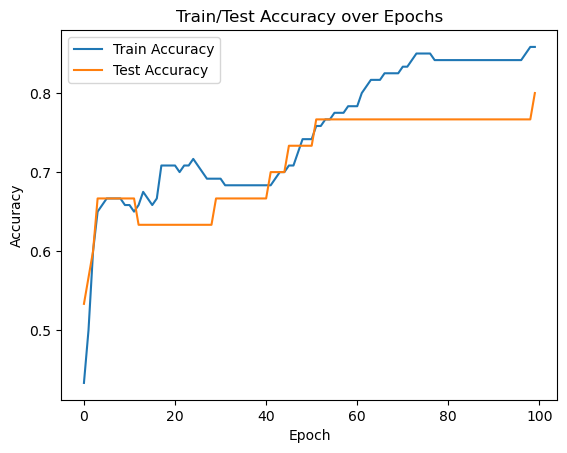

In [10]:
import matplotlib.pyplot as plt

plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train/Test Accuracy over Epochs")
plt.show()

### Experiment

Now you can experiment with different network architectures to see how it affects the result. Try:
1. One-layer network with 3 neurons (equal to the number of classes)
1. Two-layer network with small/medium/large hidden layer
1. Using more layers

Make sure you observe overfitting when you are using rich model with lots of neurons (parameters).

In [12]:
# Helper functions

def create_model(input_dim, output_dims):
    layers = []
    prev_dim = input_dim
    for out_dim in output_dims[:-1]:
        layers.append(nn.Linear(prev_dim, out_dim))
        layers.append(nn.ReLU())
        prev_dim = out_dim
    # Last layer (no activation)
    layers.append(nn.Linear(prev_dim, output_dims[-1]))
    return nn.Sequential(*layers)

def train_model(model, X_train, y_train, X_test, y_test, num_epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "train_acc": [], "test_acc": []}
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            train_pred = torch.argmax(model(X_train), dim=1)
            train_acc = (train_pred == y_train).float().mean().item()
            test_pred = torch.argmax(model(X_test), dim=1)
            test_acc = (test_pred == y_test).float().mean().item()
        history["train_loss"].append(loss.item())
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    return history

def plot_acc(history):
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["test_acc"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Train/Test Accuracy over Epochs")
    plt.show()


Epoch [10/100], Loss: 1.1267, Train Acc: 0.3333, Test Acc: 0.3333
Epoch [20/100], Loss: 1.0769, Train Acc: 0.3333, Test Acc: 0.3333
Epoch [30/100], Loss: 1.0096, Train Acc: 0.3333, Test Acc: 0.3333
Epoch [40/100], Loss: 0.9225, Train Acc: 0.3333, Test Acc: 0.3333
Epoch [50/100], Loss: 0.8284, Train Acc: 0.5417, Test Acc: 0.5667
Epoch [60/100], Loss: 0.7444, Train Acc: 0.9167, Test Acc: 0.8333
Epoch [70/100], Loss: 0.6753, Train Acc: 0.9333, Test Acc: 0.8333
Epoch [80/100], Loss: 0.6183, Train Acc: 0.9583, Test Acc: 0.8667
Epoch [90/100], Loss: 0.5702, Train Acc: 0.9583, Test Acc: 0.9000
Epoch [100/100], Loss: 0.5282, Train Acc: 0.9583, Test Acc: 0.9000


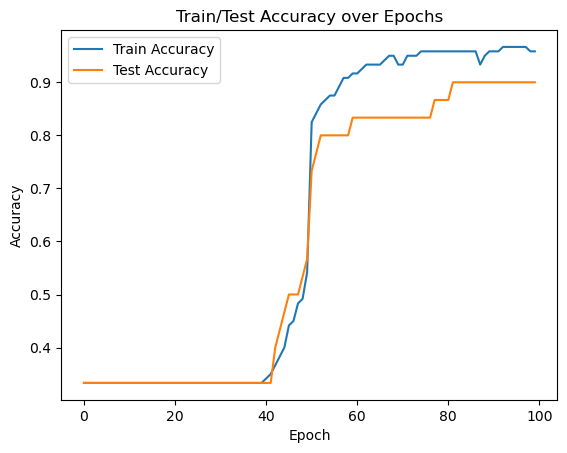

In [14]:
two_layer_small_hidden_model = create_model(4, [3, 3])
history_two_layer_small = train_model(two_layer_small_hidden_model, X_train, y_train, X_test, y_test)
plot_acc(history_two_layer_small)

Epoch [10/100], Loss: 1.0947, Train Acc: 0.3333, Test Acc: 0.3333
Epoch [20/100], Loss: 1.0570, Train Acc: 0.5167, Test Acc: 0.4667
Epoch [30/100], Loss: 0.9971, Train Acc: 0.6583, Test Acc: 0.6333
Epoch [40/100], Loss: 0.9029, Train Acc: 0.6000, Test Acc: 0.5667
Epoch [50/100], Loss: 0.7886, Train Acc: 0.4167, Test Acc: 0.4333
Epoch [60/100], Loss: 0.6775, Train Acc: 0.6667, Test Acc: 0.6667
Epoch [70/100], Loss: 0.5901, Train Acc: 0.6667, Test Acc: 0.6667
Epoch [80/100], Loss: 0.5279, Train Acc: 0.6750, Test Acc: 0.7000
Epoch [90/100], Loss: 0.4810, Train Acc: 0.8500, Test Acc: 0.8000
Epoch [100/100], Loss: 0.4410, Train Acc: 0.9083, Test Acc: 0.9333


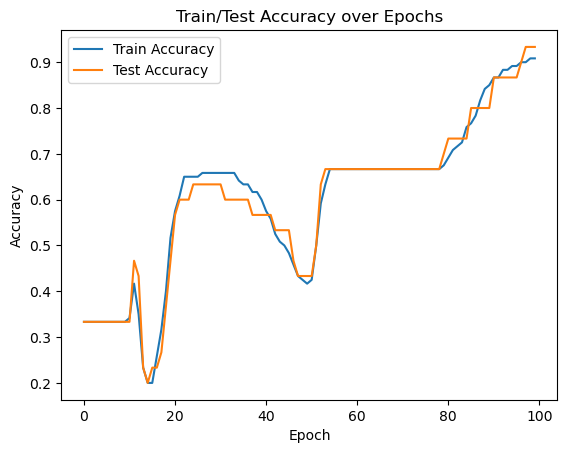

In [15]:
medium_hidden_model = create_model(4, [8, 3])
history_medium_hidden = train_model(medium_hidden_model, X_train, y_train, X_test, y_test)
plot_acc(history_medium_hidden)



Epoch [10/100], Loss: 0.9368, Train Acc: 0.6667, Test Acc: 0.6667
Epoch [20/100], Loss: 0.6788, Train Acc: 0.7417, Test Acc: 0.7667
Epoch [30/100], Loss: 0.4813, Train Acc: 0.8833, Test Acc: 0.7667
Epoch [40/100], Loss: 0.3660, Train Acc: 0.9167, Test Acc: 0.9333
Epoch [50/100], Loss: 0.2827, Train Acc: 0.9500, Test Acc: 0.9667
Epoch [60/100], Loss: 0.2177, Train Acc: 0.9667, Test Acc: 0.9667
Epoch [70/100], Loss: 0.1718, Train Acc: 0.9667, Test Acc: 0.9667
Epoch [80/100], Loss: 0.1396, Train Acc: 0.9667, Test Acc: 0.9667
Epoch [90/100], Loss: 0.1168, Train Acc: 0.9667, Test Acc: 0.9667
Epoch [100/100], Loss: 0.1004, Train Acc: 0.9750, Test Acc: 0.9667


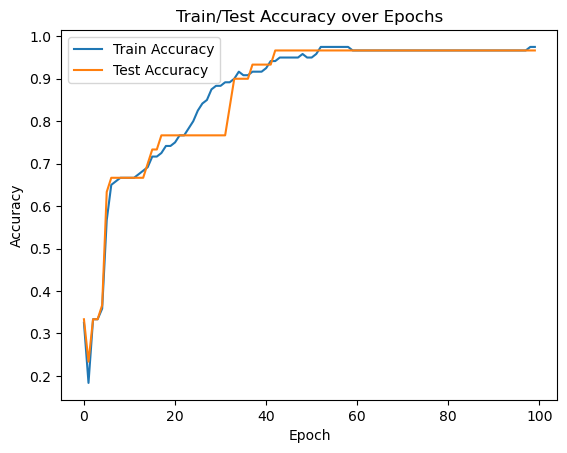

In [16]:
large_hidden_model = create_model(4, [32, 3])
history_large_hidden = train_model(large_hidden_model, X_train, y_train, X_test, y_test)
plot_acc(history_large_hidden)

Epoch [10/100], Loss: 0.8464, Train Acc: 0.6667, Test Acc: 0.6667
Epoch [20/100], Loss: 0.3167, Train Acc: 0.9667, Test Acc: 0.9667
Epoch [30/100], Loss: 0.0914, Train Acc: 0.9667, Test Acc: 0.9333
Epoch [40/100], Loss: 0.0462, Train Acc: 0.9833, Test Acc: 1.0000
Epoch [50/100], Loss: 0.0417, Train Acc: 0.9833, Test Acc: 1.0000
Epoch [60/100], Loss: 0.0406, Train Acc: 0.9833, Test Acc: 1.0000
Epoch [70/100], Loss: 0.0412, Train Acc: 0.9833, Test Acc: 0.9667
Epoch [80/100], Loss: 0.0392, Train Acc: 0.9833, Test Acc: 1.0000
Epoch [90/100], Loss: 0.0379, Train Acc: 0.9833, Test Acc: 1.0000
Epoch [100/100], Loss: 0.0370, Train Acc: 0.9833, Test Acc: 1.0000


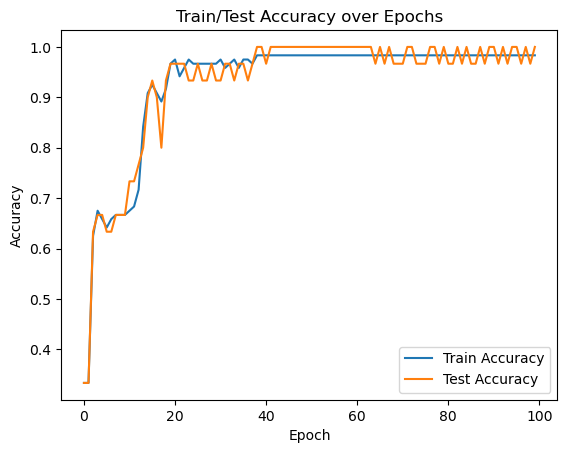

In [17]:
three_layer_large_model = create_model(4, [64, 32, 16, 3])
history_three_layer_large = train_model(three_layer_large_model, X_train, y_train, X_test, y_test)
plot_acc(history_three_layer_large)

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, so you can easily get it with a couple of lines of code ([Keras](https://keras.io/api/datasets/mnist/), [PyTorch](https://pytorch.org/vision/stable/datasets.html)). You will also be able to load both train and test datasets without manually splitting them.

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = mnist_train.data.view(-1, 28*28).float() / 255.0
y_train = mnist_train.targets
X_test = mnist_test.data.view(-1, 28*28).float() / 255.0
y_test = mnist_test.targets

Epoch [10/100], Loss: 2.0169, Train Acc: 0.6334, Test Acc: 0.6395
Epoch [20/100], Loss: 1.3859, Train Acc: 0.7542, Test Acc: 0.7615
Epoch [30/100], Loss: 0.7815, Train Acc: 0.8323, Test Acc: 0.8370
Epoch [40/100], Loss: 0.5006, Train Acc: 0.8679, Test Acc: 0.8717
Epoch [50/100], Loss: 0.3959, Train Acc: 0.8893, Test Acc: 0.8944
Epoch [60/100], Loss: 0.3461, Train Acc: 0.9019, Test Acc: 0.9068
Epoch [70/100], Loss: 0.3153, Train Acc: 0.9101, Test Acc: 0.9122
Epoch [80/100], Loss: 0.2932, Train Acc: 0.9165, Test Acc: 0.9186
Epoch [90/100], Loss: 0.2760, Train Acc: 0.9214, Test Acc: 0.9226
Epoch [100/100], Loss: 0.2617, Train Acc: 0.9259, Test Acc: 0.9268


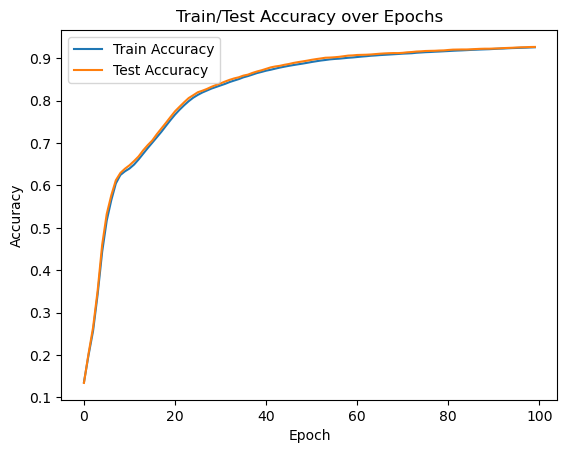

In [21]:
mnist_model = create_model(28*28, [128, 64, 10])
history_mnist = train_model(mnist_model, X_train, y_train, X_test, y_test, num_epochs=100, lr=0.001)
plot_acc(history_mnist)

Now you need to perform the steps above to make sure dataset is normalized (it would probably already be), defining and training a neural network.

## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.